In [4]:
import glob
import numpy as np
import pandas as pd

#shuffel the events by people
def shuffle(name, num):
    data_columns = ['x axis', 'y axis',  'z axis', 'activity']
    data = pd.DataFrame(columns=data_columns)
    #read all t
    for n in name :
        all_files = glob.glob("categorized_data/" + n + "*")
        for file_name in all_files :
            data = data.append(pd.read_csv(file_name, usecols=data_columns))
    num = num * 32
    d = data.set_index(np.arange(len(data)) // num, append=True).swaplevel(0, 1)
    shuffled = pd.concat([d.xs(i) for i in np.random.permutation(range(len(data) // num))])
    shuffled.to_csv("shuffled.csv")
    return shuffled
# shuffled = shuffle('f1', 5)

In [41]:
import glob
import random
import pandas as pd
def newShuffle():
    data_columns = ['x axis', 'y axis',  'z axis', 'activity']
    data = pd.DataFrame(columns=data_columns)
    all_files = glob.glob("categorized_data/*")
    random.shuffle(all_files)
    for file_name in all_files:
        data = data.append(pd.read_csv(file_name, usecols=data_columns))
    for col in data_columns[:3]:
        data[col] = (data[col]  * 3.0 / 63.0 - 1.5) * 9.8
    return data
shuffled = newShuffle()

In [44]:
#save the correct seperations into bars
labels = shuffled['activity'].values
bars = []
num = len(labels)
step = 64
for i in range(0, num, 32):
    if (i + 33) > num: 
        break
    if labels[i] == labels[i + 32]:
        bars.append(0)
    else:
        bars.append(1)

In [45]:
#funciton to calculate the dtw score
def dtw_calculation(total_a, size, factor):
    window_size = 32 * size
    overlap = int(window_size * (1-factor))
    segment_a = []
    for i in range(0, len(total_a), overlap):
        if i + window_size <= len(total_a):
            if i + window_size >= len(total_a):
                break
            a1 = [total_a[i:i+window_size]]
            segment_a.extend(a1)
    a_score = []
    for i in tqdm(range(1,len(segment_a))):
        signal = segment_a[i]
        signal_com = segment_a[i-1]
#     distance,_= fastdtw(signal,signal_com, dist=euclidean)
        euclidean_norm = lambda x, y: np.abs(x - y)
        distance, cost_matrix, acc_cost_matrix, path = dtw(signal,signal_com, dist=euclidean_norm)
        a_score.append(distance)
    return a_score

In [46]:
import numpy as np
from tqdm import tqdm
from fastdtw import fastdtw
from dtw import dtw
from scipy.spatial.distance import euclidean,sqeuclidean
#apply dtw to shuffled data
shuffled = shuffled.assign(a =lambda x: (x['x axis']**2 + x['y axis']**2 + x['z axis']**2))
shuffled['a'] = np.sqrt(shuffled[['a']].sum(axis=1)).astype(int)
total_a = shuffled['a'].values

a_score_1_0 = dtw_calculation(total_a, 1, 0)
a_score_3_0 = dtw_calculation(total_a, 3, 0)
a_score_3_1 = dtw_calculation(total_a, 3, 0.1)
a_score_3_3 = dtw_calculation(total_a, 3, 0.3)
a_score_5_0 = dtw_calculation(total_a, 5, 0)
a_score_5_1 = dtw_calculation(total_a, 5, 0.1)
a_score_5_3 = dtw_calculation(total_a, 5, 0.3)
a_score_4_1 = dtw_calculation(total_a, 4, 0.1)

100%|██████████| 3932/3932 [03:21<00:00, 18.84it/s]


In [47]:
def evaluate(bars, sample_bar, toleration):
    count = 0
    true = 0
    total = 0
    seg = 0
    num = len(sample_bar)
    for i in range(len(bars)):
        if i >= num:
            break
        if sample_bar[i] == 1:
            seg +=1
        if bars[i] == 1:
            total += 1
            if toleration == 0:
                if sample_bar[i] == 0:
                    count += 1
                else:
                    true += 1
            else:
                check = true
                for x in range(-1*toleration, toleration):
                    check = check & (sample_bar[i + x] == 0)
                if check:
                    count += 1
                else:
                    true += 1
    print 'miscounted --> ' + str(np.true_divide(count, total)* 100) + '%'
    print 'valid segmentation --> ' + str(np.true_divide(true, seg)* 100) + '%'

In [78]:
def evalu(scores, limit, duration, overlap, toleration):
    sample_bar = []
    for score in scores:
        for i in range(duration - overlap):
            sample_bar.append(0)
        if score > limit:
            sample_bar.append(1)
        else:
            sample_bar.append(0)
    evaluate(bars, sample_bar, toleration)

In [79]:
evalu(a_score_1_0, 0.05, 1, 0, 0)
evalu(a_score_3_0, 0.005, 3, 0, 0)
evalu(a_score_3_1, 0.1, 3, 1, 0)
evalu(a_score_3_3, 0.05, 3, 3, 0)
evalu(a_score_5_0, 0.5, 5, 0, 0)
evalu(a_score_5_1, 0.05, 5, 1, 0)
evalu(a_score_5_3, 0.05, 5, 3, 0)
evalu(a_score_4_1, 0.5, 4, 1, 0)

miscounted --> 64.63414634146342%
valid segmentation --> 0.48641395504864143%
miscounted --> 80.48780487804879%
valid segmentation --> 0.45351473922902497%
miscounted --> 75.60975609756098%
valid segmentation --> 0.5386479935362241%
miscounted --> 2.7777777777777777%
valid segmentation --> 0.581781914893617%
miscounted --> 98.78048780487805%
valid segmentation --> 0.2985074626865672%
miscounted --> 82.92682926829268%
valid segmentation --> 0.5380476556495004%
miscounted --> 67.64705882352942%
valid segmentation --> 0.5955603681645912%
miscounted --> 95.1219512195122%
valid segmentation --> 0.7874015748031495%


In [108]:
evaluate(bars, sample_bar)

miscounted --> 12.200956937799043%
valid segmentation --> 30.17471736896197%


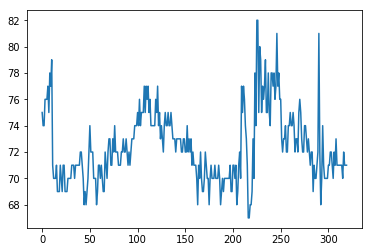

In [42]:
plt.plot(total_a[32*5:32*15])

In [32]:
bars

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
